# Milk Grade Classification

Coded by Luna McBride

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #plotting
%matplotlib inline

plt.rcParams['figure.figsize'] = (15,10) #Set the default figure size
plt.style.use('ggplot') #Set the plotting method

from sklearn.model_selection import train_test_split #Split the data into train and test
from sklearn.ensemble import RandomForestClassifier #Forest for prediction and regression
from sklearn.metrics import mean_squared_error #Error testing
from sklearn.metrics import classification_report #Report of Classification

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/milk-grading/Milk Grading (1).csv


In [2]:
milk = pd.read_csv("../input/milk-grading/Milk Grading (1).csv") #Get the milk dataset
milk.head() #Take a peek at the milk

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,1.0
1,6.6,36,0,1,0,1,253,1.0
2,8.5,70,1,1,1,1,246,0.0
3,9.5,34,1,1,0,1,255,0.0
4,6.6,37,0,0,0,0,255,0.5


---

# Check for Null Values

In [3]:
print(milk.isnull().any()) #Check for null values

pH            False
Temprature    False
Taste         False
Odor          False
Fat           False
Turbidity     False
Colour        False
Grade         False
dtype: bool


There are no null values.

---

# Add a Column Putting Grade into Words

In [4]:
milk["gradeWord"] = milk["Grade"].apply(lambda x: "Good" if x==1 else ("Moderate" if x==0.5 else "Bad") ) #Put the grade into words
milk.head() #Take a peek at the dataset

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade,gradeWord
0,6.6,35,1,0,1,0,254,1.0,Good
1,6.6,36,0,1,0,1,253,1.0,Good
2,8.5,70,1,1,1,1,246,0.0,Bad
3,9.5,34,1,1,0,1,255,0.0,Bad
4,6.6,37,0,0,0,0,255,0.5,Moderate


---

# Basic Exploration

## Number of Rows

In [5]:
print(len(milk.index)) #Check the number of rows

1059


There are only 1059 entries.

## Count of Grades

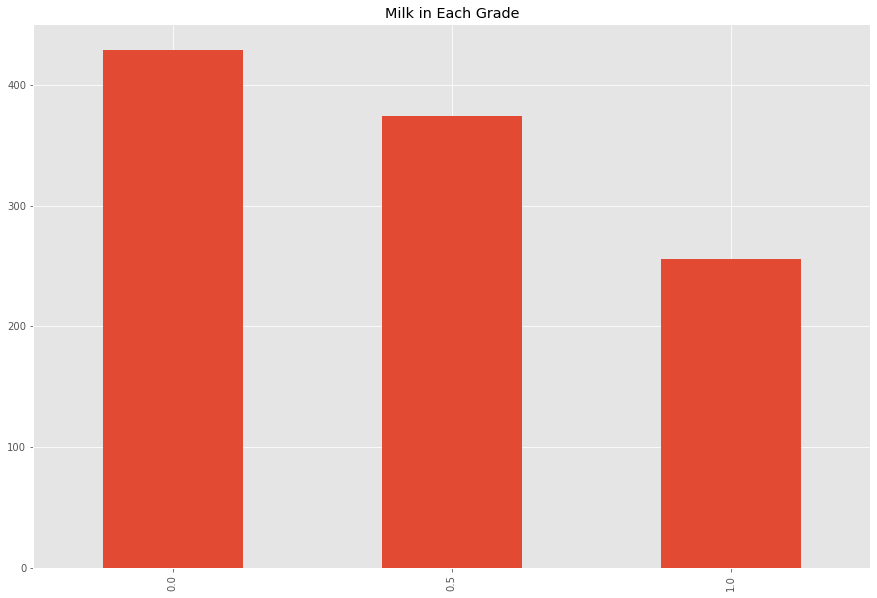

In [6]:
milk["Grade"].value_counts().plot.bar(title = "Milk in Each Grade") #Plot the number of instances of each grade

It appears there are more grade 0 and 0.5 milks than 1.0, but not by too much.

## Range of Temperature/PH Values

In [7]:
rangeValues = ["Temprature", "pH", "Colour"] #Get the columns that are ranged values

#For each ranged value column, print the range of the column (min and max)
for column in rangeValues:
    #Print the range for these columns that have ranges
    print(column, "Range: ", milk[column].unique().min(), "-", milk[column].unique().max())

Temprature Range:  34 - 90
pH Range:  3.0 - 9.5
Colour Range:  240 - 255


In [8]:
gradeType = ["Good", "Moderate", "Bad"] #Get the word names for the different grades

#For each grade, get the subset of the dataset for that grade and get its pH/Temp ranges
for grade in gradeType:
    subset = milk.loc[milk["gradeWord"] == grade] #Get the subset of the data for the specific grade
    
    #For each ranged value column, print the range of the column (min and max) per each grade
    for column in rangeValues:
        #Print the range for these columns that have ranges
        print(grade, column, "Range: ", subset[column].unique().min(), "-", subset[column].unique().max())

Good Temprature Range:  35 - 45
Good pH Range:  6.5 - 6.8
Good Colour Range:  245 - 255
Moderate Temprature Range:  34 - 45
Moderate pH Range:  6.4 - 6.8
Moderate Colour Range:  240 - 255
Bad Temprature Range:  34 - 90
Bad pH Range:  3.0 - 9.5
Bad Colour Range:  245 - 255


The general ranges for the whole dataset appear to be 34-90, 3-9.5, and 240-255 for temperature, pH, and colour respectively. This also appears to be the total range for bad milks in the case of temperature and pH, where both moderate and good are more restrictive in those departments yet similar to one another. This tells be there are different criteria to deciding good/moderate vs bad and good vs moderate, so those may need to have different classification models to determine the characteristics.

As for colour, it seems to only come into play with moderate milks. This means it could be a factor in the difference between moderate and good, but we will have to see.

## Plot Each Column

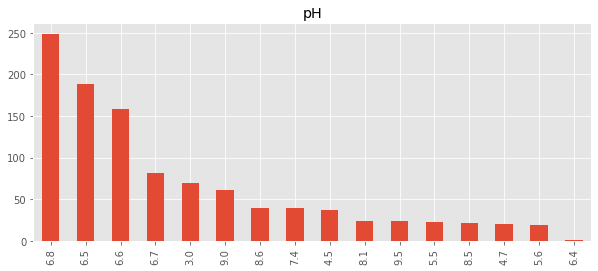

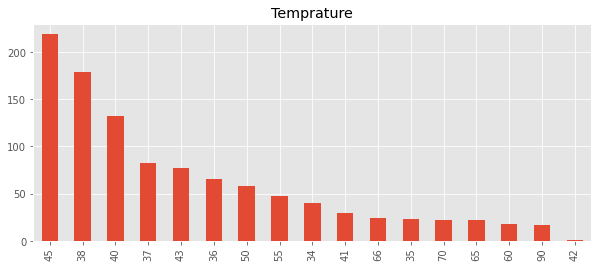

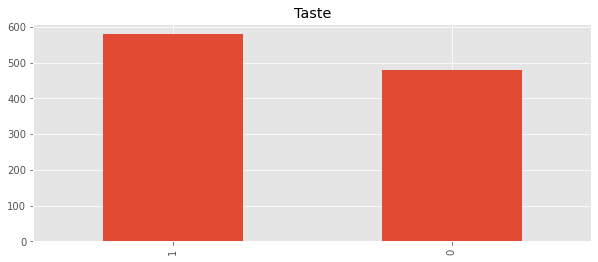

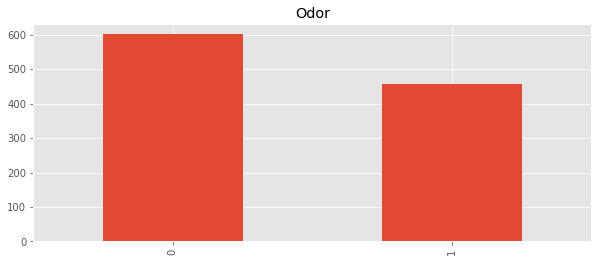

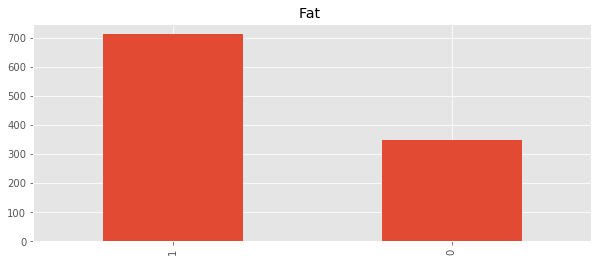

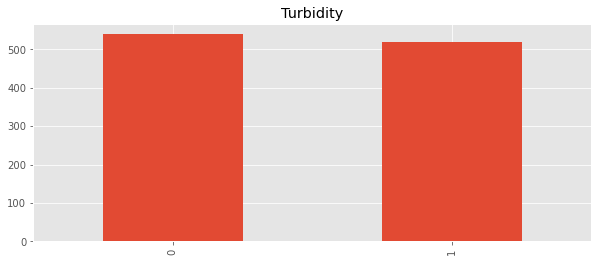

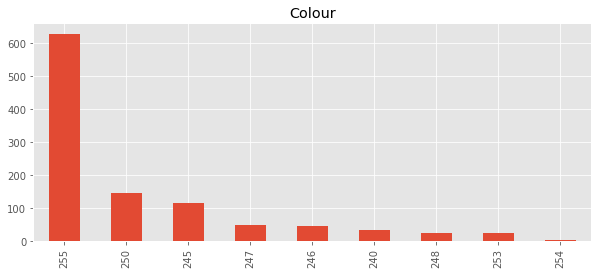

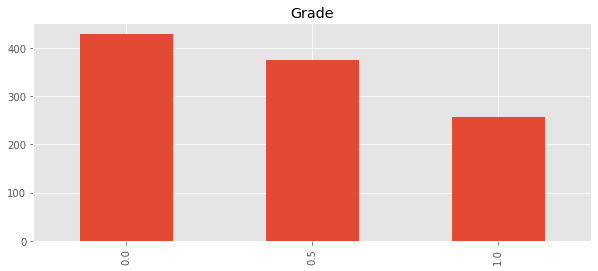

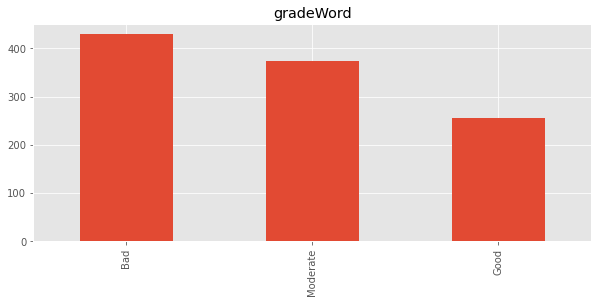

In [9]:
plt.rcParams['figure.figsize'] = (10,4) #Update the graph sizes

#For each milk column, plot it in a bar graph
for column in milk.columns:
    plt.figure() #Get the figure so it will let me plot multiple
    milk[column].value_counts().plot.bar(title = column) #Plot the specified column

The undiscussed columns appear to all be boolean in nature, with similar distributions of those to boot. The other variables, especially the ranged variables from earlier, have higher concentrations of values in the range used for good/moderate milk overall. 

---

# Classify the Whole Dataset

In [10]:
#GetChara: Get the most important characteristics to the classification
#Input: the characteristics, the model
#Output: None
def getChara(characteristics, forest):
    attributes = characteristics.columns #Get the tested attributes
    attributes = list(zip(attributes, forest.feature_importances_)) #Zip the attributes together with their coefficient
    sortAtt = sorted(attributes, key = lambda x: x[1], reverse = True) #Sort the zipped attributes by their coefficients

    print("According to the Random Forest, the most important factors for milk grade are: ") #Start printing the most important labels
    i = 0 #Counter variable so only the top five are printed

    #For each attribute in the sorted attributes
    for label, coef in sortAtt:
        if i < 7: #If there has not been five printed yet
            print(label) #Print the label as an important factor
        i += 1 #Increase i by 1

#ClassifyMilk: Classify milk grade based on the labels
#Input: The dataframe for the milk, the labels used
#Output: None
def classifyMilk(milk, labels):
    grade = milk["gradeWord"].copy() #Get the grades as our classification metric
    grade = pd.get_dummies(grade) #Get dummies for the grade metric
    print(grade)

    characteristics = milk.drop(columns = {"Grade", "gradeWord"}).copy() #Get the characteristics used for classification
    charaTrain, charaTest, gradeTrain, gradeTest = train_test_split(characteristics, grade, test_size = 0.2) #Split the dataset
    
    forest = RandomForestClassifier(n_estimators = 100) #Build a forest
    forest.fit(charaTrain, gradeTrain) #Fit the forest model
    
    predict = forest.predict(charaTest) #Get a list of predictions
    
    print("Forest Accuracy: ", forest.score(charaTest, gradeTest)) #Print the accuracy
    print("Root Mean Square Error: ", np.sqrt(mean_squared_error(gradeTest, predict))) #Print the root mean square error
    print("Classification Report:\n ", classification_report(gradeTest, predict, target_names = labels)) #Print a classification report
    
    getChara(characteristics, forest) #Get the important Characteristics

In [11]:
grade = ["Bad", "Good", "Moderate"] #Get the grades in order
classifyMilk(milk, grade) #Classify on the whole dataset

      Bad  Good  Moderate
0       0     1         0
1       0     1         0
2       1     0         0
3       1     0         0
4       0     0         1
...   ...   ...       ...
1054    0     0         1
1055    0     1         0
1056    1     0         0
1057    0     1         0
1058    1     0         0

[1059 rows x 3 columns]
Forest Accuracy:  1.0
Root Mean Square Error:  0.0
Classification Report:
                precision    recall  f1-score   support

         Bad       1.00      1.00      1.00        82
        Good       1.00      1.00      1.00        59
    Moderate       1.00      1.00      1.00        71

   micro avg       1.00      1.00      1.00       212
   macro avg       1.00      1.00      1.00       212
weighted avg       1.00      1.00      1.00       212
 samples avg       1.00      1.00      1.00       212

According to the Random Forest, the most important factors for milk grade are: 
pH
Temprature
Odor
Fat 
Turbidity
Colour
Taste


In the overall dataset (showing good/moderate versus bad), pH and Temperature come out on top as expected by looking at their ranges. Next comes Turbidity, Odor, and Fat, or rather it is considered worse if it is too foggy, too stinky, or had not enough fat.

---

# Classify only Moderate and Good

In [12]:
grades = ["Good", "Moderate"] #Get the grades for this classification
milkLite = milk.loc[milk["gradeWord"] != "Bad"] #Get all milks that are not bad

classifyMilk(milkLite, grades) #Classify every milk but bad

      Good  Moderate
0        1         0
1        1         0
4        0         1
5        1         0
9        0         1
...    ...       ...
1050     1         0
1052     0         1
1054     0         1
1055     1         0
1057     1         0

[630 rows x 2 columns]
Forest Accuracy:  0.9920634920634921
Root Mean Square Error:  0.0890870806374748
Classification Report:
                precision    recall  f1-score   support

        Good       1.00      0.98      0.99        45
    Moderate       0.99      1.00      0.99        81

   micro avg       0.99      0.99      0.99       126
   macro avg       0.99      0.99      0.99       126
weighted avg       0.99      0.99      0.99       126
 samples avg       0.99      0.99      0.99       126

According to the Random Forest, the most important factors for milk grade are: 
Fat 
Odor
pH
Turbidity
Colour
Temprature
Taste


pH and Turbidity appeared to have more of a play when looking at bad milk rather than moderate vs good, but they do appear to still be relatively important. Fat and Odor took over when calling between moderate and good, telling me that these are the factors to distinguish between moderate and good milks.

---

# Conclusion

Overall, a random forest classifier could classify the milk grades at 99+% accuracy. The pH, Temperature, and Turbidity factors had the most at play when distinguishing bad milk, while Fat and Odor were the deciding calls between moderate and good milk. This, of course, is given the wide range of temperatures and pH's in the bad milk that are picked out before even being considered to the moderate/good categories.